In [1]:
#https://drive.google.com/drive/folders/1932DHC9OX9VSbB8V2k8VG9uh9ly7qKdT?usp=sharing
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import plotly.graph_objects as go
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import poisson
from scipy.stats import geom
from scipy.stats import binom
import random
import copy
from scipy import stats
import statistics
from scipy.stats import gamma

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **1. Loading and Cleaning Data**
---

In this section, we load, clean, and sanitize our data

---

 Loading Covid Data

In [0]:
usCovidDaily = pd.read_csv("/content/drive/My Drive/CSE544_Project_Submission/us_covid19_daily.csv")
usCovidStatesDaily = pd.read_csv("/content/drive/My Drive/CSE544_Project_Submission/us_states_covid19_daily.csv")

Loading X - Stock Indices Data

In [0]:
dowjones = pd.read_csv("/content/drive/My Drive/CSE544_Project_Submission/dowjones.csv")
nasdaq = pd.read_csv("/content/drive/My Drive/CSE544_Project_Submission/nasdaq.csv")
snp500 = pd.read_csv("/content/drive/My Drive/CSE544_Project_Submission/snp500.csv")

**Sanitizing Data and Outlier Detection**

Sanitizing Covid Data

In [5]:
usCovidStatesDaily.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200509,AK,378.0,26071.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,318.0,C,5/9/2020 00:00,81730ed56f3a546adb227bf046219933797f9cbb,2020-05-09T20:00:00Z,10.0,NaN,26449,26449,26449,2,0.0,0.0,975.0,1.0,976.0
1,20200509,AL,9567.0,115927.0,NaN,NaN,1228.0,NaN,459.0,NaN,272.0,NaN,B,5/9/2020 00:00,7c1a5067467c6ce495a787917ddccae550e81335,2020-05-09T20:00:00Z,388.0,1228.0,125494,125494,125494,1,13.0,21.0,5034.0,346.0,5380.0
2,20200509,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,96.0,2968.0,B,5/9/2020 10:15,64db20aa3b59b76ce6735254a2bb4e60fe5ecede,2020-05-09T20:00:00Z,88.0,471.0,65528,65528,65528,5,0.0,5.0,1481.0,53.0,1534.0
3,20200509,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,5/3/2020 00:00,b6693293693460b7260be24906ab0d08dd930dfc,2020-05-09T20:00:00Z,0.0,NaN,83,83,83,60,0.0,0.0,0.0,0.0,0.0
4,20200509,AZ,10960.0,117980.0,NaN,739.0,1514.0,296.0,NaN,186.0,NaN,2684.0,A+,5/9/2020 00:00,e83f3a1b741065e7de9a2cc289d06e77bbc2c72f,2020-05-09T20:00:00Z,532.0,1514.0,128940,128940,128940,4,15.0,32.0,8599.0,434.0,9033.0


Keeping only 48 contigous US states

In [6]:
statesToRemove = ['AK', 'HI', 'AS', 'GU', 'MP', 'PR', 'VI', 'DC']
usCovidStatesDaily = usCovidStatesDaily[~usCovidStatesDaily.state.isin(statesToRemove)]
#usCovidStatesDaily.shape
usCovidStatesDaily.columns #check columns present

Index(['date', 'state', 'positive', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'dataQualityGrade', 'lastUpdateEt', 'hash', 'dateChecked',
       'death', 'hospitalized', 'total', 'totalTestResults', 'posNeg', 'fips',
       'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease',
       'positiveIncrease', 'totalTestResultsIncrease'],
      dtype='object')

Maintaining only columns of Interest

In [7]:
usCovidStatesDaily = usCovidStatesDaily[['date', 'state', 'positive', 'negative', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently','inIcuCumulative','onVentilatorCurrently','onVentilatorCumulative','recovered', 'death', 'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease','totalTestResults','totalTestResultsIncrease']]
usCovidStatesDaily.columns

Index(['date', 'state', 'positive', 'negative', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'death',
       'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease',
       'positiveIncrease', 'totalTestResults', 'totalTestResultsIncrease'],
      dtype='object')

Outlier Analysis using Tukey's rule

In [8]:
#Finding IQR for each state and then removing outliers using Tukey's rule

def RemoveOutliers(statedf,tempdf):
  #sns.boxplot(x=statedf['positiveIncrease'])
  usCovidStatesDailyQ1 = statedf.quantile(0.25) #left quantile
  usCovidStatesDailyQ3 = statedf.quantile(0.75) #right quantile
  IQR = usCovidStatesDailyQ3 - usCovidStatesDailyQ1  
  statedf = statedf[~((statedf < (usCovidStatesDailyQ1 - 5 * IQR)) | (statedf > (usCovidStatesDailyQ3 + 5 * IQR))).any(axis=1)] #filtering on iqr using tukey's rule
  tempdf = pd.concat([tempdf,statedf])
  return tempdf

tempdf = usCovidStatesDaily.copy()
tempdf.drop(tempdf.index, inplace=True)
print("Number of data rows before removing outliers:",usCovidStatesDaily.shape[0])
usStates = usCovidStatesDaily['state'].unique()
for i in range(0,len(usStates)):
    state = usStates[i] 
    statedata = usCovidStatesDaily[usCovidStatesDaily['state']==state]
    tempdf = RemoveOutliers(statedata,tempdf) #remove outliers from state and merge back with master dataframe
print("Number of data rows after removing outliers:",tempdf.shape[0])
print("Total outliers removed:",usCovidStatesDaily.shape[0]-tempdf.shape[0] )
usCovidStatesDaily = tempdf

Number of data rows before removing outliers: 3187
Number of data rows after removing outliers: 3021
Total outliers removed: 166


Check if datatypes of all columns are correct

In [9]:
usCovidStatesDaily.dtypes

date                          int64
state                        object
positive                    float64
negative                    float64
hospitalizedCurrently       float64
hospitalizedCumulative      float64
inIcuCurrently              float64
inIcuCumulative             float64
onVentilatorCurrently       float64
onVentilatorCumulative      float64
recovered                   float64
death                       float64
deathIncrease               float64
hospitalizedIncrease        float64
negativeIncrease            float64
positiveIncrease            float64
totalTestResults              int64
totalTestResultsIncrease    float64
dtype: object

In [0]:
#Converting date to a datetime object
usCovidStatesDaily["date"] = pd.to_datetime(usCovidStatesDaily["date"], format='%Y%m%d')

Replacing NaN's with 0 as we will be dealing with numeric data

In [11]:
print(usCovidStatesDaily.isna().any())
usCovidStatesDaily = usCovidStatesDaily.fillna(0.0) #replace NaNs with 0
print("\nAfter cleaning:")
print(usCovidStatesDaily.isna().any())

date                        False
state                       False
positive                    False
negative                     True
hospitalizedCurrently        True
hospitalizedCumulative       True
inIcuCurrently               True
inIcuCumulative              True
onVentilatorCurrently        True
onVentilatorCumulative       True
recovered                    True
death                        True
deathIncrease                True
hospitalizedIncrease         True
negativeIncrease             True
positiveIncrease             True
totalTestResults            False
totalTestResultsIncrease     True
dtype: bool

After cleaning:
date                        False
state                       False
positive                    False
negative                    False
hospitalizedCurrently       False
hospitalizedCumulative      False
inIcuCurrently              False
inIcuCumulative             False
onVentilatorCurrently       False
onVentilatorCumulative      False
recovered          

Consider a time frame from first february till 30th April for consistency

In [0]:
start_date = '2020-01-31'
end_date = '2020-05-01'
usCovidStatesDaily = usCovidStatesDaily[(usCovidStatesDaily['date'] > start_date ) & (usCovidStatesDaily['date'] < end_date)] #Filter on range of dates
usCovidStatesDaily = usCovidStatesDaily.sort_values(['date'],ascending=True).reset_index(drop=True) #Sort by date

Aggregate Data for states and store seperately

In [0]:
usCovidDaily = usCovidStatesDaily.groupby('date').agg({'positive' : 'sum', 'negative' : 'sum', 'hospitalizedCurrently' : 'sum', 'hospitalizedCumulative' : 'sum', 'recovered' : 'sum', 'death' : 'sum', 'deathIncrease' : 'sum', 'hospitalizedIncrease' : 'sum', 'negativeIncrease' : 'sum', 'positiveIncrease' : 'sum'})
usCovidDaily = usCovidDaily.reset_index()

**Sanitizing X Dataset**

Checking for NaN values

In [14]:
dowjones.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-04-22,26553.050781,26458.609375,26510.769531,26511.050781,232570000,26511.050781
1,2019-04-23,26695.960938,26503.560547,26513.830078,26656.390625,311690000,26656.390625
2,2019-04-24,26680.580078,26582.859375,26652.560547,26597.050781,283370000,26597.050781
3,2019-04-25,26536.480469,26310.279297,26426.369141,26462.080078,296730000,26462.080078
4,2019-04-26,26543.560547,26392.550781,26454.619141,26543.330078,317290000,26543.330078


In [15]:
dowjones.isna().any() #Check for NaN values

Date         False
High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

In [16]:
nasdaq.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-04-22,7746.75,7669.75,7715.25,7734.75,393586.0,7734.75
1,2019-04-23,7843.75,7724.50,7738.00,7838.00,253668.0,7838.00
2,2019-04-24,7852.75,7802.25,7833.50,7847.75,427149.0,7847.75
3,2019-04-25,7879.50,7792.00,7855.25,7798.50,387633.0,7798.50
4,2019-04-26,7845.50,7755.50,7799.25,7840.25,488329.0,7840.25


In [17]:
nasdaq.isna().any()

Date         False
High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

In [18]:
snp500.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2019-04-22,2909.510010,2896.350098,2898.780029,2907.969971,2997950000,2907.969971
1,2019-04-23,2936.310059,2908.530029,2909.989990,2933.679932,3635030000,2933.679932
2,2019-04-24,2936.830078,2926.050049,2934.000000,2927.250000,3448960000,2927.250000
3,2019-04-25,2933.100098,2912.840088,2928.989990,2926.169922,3425280000,2926.169922
4,2019-04-26,2939.879883,2917.560059,2925.810059,2939.879883,3248500000,2939.879883


In [19]:
snp500.isna().any()

Date         False
High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

Applying Tukey's rule to remove outliers

In [0]:
def getIQR(df):
  dfQ1 = df.quantile(0.25)
  dfQ3 = df.quantile(0.75)
  IQR = dfQ3 - dfQ1
  return dfQ1, dfQ3, IQR

In [21]:
oldshape = dowjones.shape[0]
dowjonesQ1, dowjonesQ3, dowjonesIQR = getIQR(dowjones)
dowjones = dowjones[~((dowjones < (dowjonesQ1 - 5 * dowjonesIQR)) |(dowjones > (dowjonesQ3 + 5 * dowjonesIQR))).any(axis=1)] #Applying tukey's rule
newshape = dowjones.shape[0]
print("Percentage outliers removed for DowJones:",(oldshape-newshape)*100/oldshape)

Percentage outliers removed for DowJones: 2.380952380952381


In [22]:
oldshape = nasdaq.shape[0]
nasdaqQ1, nasdaqQ3, nasdaqIQR = getIQR(nasdaq)
nasdaq = nasdaq[~((nasdaq < (nasdaqQ1 - 5 * nasdaqIQR)) |(nasdaq > (nasdaqQ3 + 5 * nasdaqIQR))).any(axis=1)] #Applying tukey's rule
newshape = nasdaq.shape[0]
print("Percentage outliers removed for NasDaq:",(oldshape-newshape)*100/oldshape)

Percentage outliers removed for NasDaq: 7.526881720430108


In [23]:
oldshape = snp500.shape[0]
snp500Q1, snp500Q3, snp500IQR = getIQR(snp500)
snp500 = snp500[~((snp500 < (snp500Q1 - 5 * snp500IQR)) |(snp500 > (snp500Q3 + 5 * snp500IQR))).any(axis=1)] #Applying tukey's rule
newshape = snp500.shape[0]
print("Percentage of outliers removed for Snp500:",(oldshape-newshape)*100/oldshape)

Percentage of outliers removed for Snp500: 3.1746031746031744


In [24]:
dowjones = dowjones.rename(columns={'Date' : 'date'}) #santizing data
dowjones['date'] = pd.to_datetime(dowjones['date'])
dowjones.head()

,date,High,Low,Open,Close,Volume,Adj Close
0,2019-04-22,26553.050781,26458.609375,26510.769531,26511.050781,232570000,26511.050781
1,2019-04-23,26695.960938,26503.560547,26513.830078,26656.390625,311690000,26656.390625
2,2019-04-24,26680.580078,26582.859375,26652.560547,26597.050781,283370000,26597.050781
3,2019-04-25,26536.480469,26310.279297,26426.369141,26462.080078,296730000,26462.080078
4,2019-04-26,26543.560547,26392.550781,26454.619141,26543.330078,317290000,26543.330078


In [25]:
nasdaq = nasdaq.rename(columns={'Date' : 'date'})   #santizing data
nasdaq['date'] = pd.to_datetime(nasdaq['date'])
nasdaq.head()

,date,High,Low,Open,Close,Volume,Adj Close
0,2019-04-22,7746.75,7669.75,7715.25,7734.75,393586.0,7734.75
1,2019-04-23,7843.75,7724.50,7738.00,7838.00,253668.0,7838.00
2,2019-04-24,7852.75,7802.25,7833.50,7847.75,427149.0,7847.75
3,2019-04-25,7879.50,7792.00,7855.25,7798.50,387633.0,7798.50
4,2019-04-26,7845.50,7755.50,7799.25,7840.25,488329.0,7840.25


In [26]:
snp500 = snp500.rename(columns={'Date' : 'date'}) #santizing data
snp500['date'] = pd.to_datetime(snp500['date'])
snp500.head()

,date,High,Low,Open,Close,Volume,Adj Close
0,2019-04-22,2909.510010,2896.350098,2898.780029,2907.969971,2997950000,2907.969971
1,2019-04-23,2936.310059,2908.530029,2909.989990,2933.679932,3635030000,2933.679932
2,2019-04-24,2936.830078,2926.050049,2934.000000,2927.250000,3448960000,2927.250000
3,2019-04-25,2933.100098,2912.840088,2928.989990,2926.169922,3425280000,2926.169922
4,2019-04-26,2939.879883,2917.560059,2925.810059,2939.879883,3248500000,2939.879883


Merge the datasets on date

In [27]:
covid_dowjones_merged = pd.merge(usCovidStatesDaily, dowjones, on='date', how='inner')
covid_dowjones_merged = covid_dowjones_merged.fillna(0.0)
covid_dowjones_merged.head()

,date,state,positive,negative,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResults,totalTestResultsIncrease,High,Low,Open,Close,Volume,Adj Close
0,2020-02-03,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,28630.390625,28319.650391,28319.650391,28399.810547,307910000,28399.810547
1,2020-02-04,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,28904.880859,28696.740234,28696.740234,28807.630859,332750000,28807.630859
2,2020-02-05,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,29308.890625,29000.849609,29048.730469,29290.849609,357540000,29290.849609
3,2020-02-06,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,29408.050781,29246.929688,29388.580078,29379.769531,263700000,29379.769531
4,2020-02-07,WA,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,29286.919922,29056.980469,29286.919922,29102.509766,252860000,29102.509766


In [28]:
covid_nasdaq_merged = pd.merge(usCovidStatesDaily, nasdaq, on='date', how='inner')
covid_nasdaq_merged = covid_nasdaq_merged.fillna(0.0)
covid_nasdaq_merged.head()

,date,state,positive,negative,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResults,totalTestResultsIncrease,High,Low,Open,Close,Volume,Adj Close
0,2020-02-02,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,9038.25,8975.00,8982.75,9029.50,459823.0,9029.50
1,2020-02-03,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,9155.75,8975.00,8982.75,9114.25,898384.0,9114.25
2,2020-02-04,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,9369.25,9073.00,9099.00,9355.00,680726.0,9355.00
3,2020-02-05,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,9462.75,9317.75,9357.00,9381.50,563913.0,9381.50
4,2020-02-06,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,9464.00,9362.50,9390.00,9455.50,729548.0,9455.50


In [29]:
covid_snp500_merged = pd.merge(usCovidStatesDaily, snp500, on='date', how='inner')
covid_snp500_merged = covid_snp500_merged.fillna(0.0)
covid_snp500_merged.head()

,date,state,positive,negative,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResults,totalTestResultsIncrease,High,Low,Open,Close,Volume,Adj Close
0,2020-02-03,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,3268.439941,3235.659912,3235.659912,3248.919922,3757910000,3248.919922
1,2020-02-04,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,3306.919922,3280.610107,3280.610107,3297.590088,3995320000,3297.590088
2,2020-02-05,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,3337.580078,3313.750000,3324.909912,3334.689941,4117730000,3334.689941
3,2020-02-06,WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,3347.959961,3334.389893,3344.919922,3345.780029,3868370000,3345.780029
4,2020-02-07,WA,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,3341.419922,3322.120117,3335.540039,3327.709961,3730650000,3327.709961


**Steps, Observations and findings:**

After loading the Covid data, we filtered out data for 48 contiguous states of US and truncated unnecessary columns. We then applied Tukey's rule to remove outliers state wise based on inter-quantile range. For an iqr multiplier of 1.5, we were losing around 20% of our data to outliers. Hence we increased the multiplier further that started flattening the number of outliers detected around a range of 5 and above. At this value of the multiplier (5), we are removing around 5% outliers from our Covid data. We then ran sanity checks like checking if datatypes of all columns are correct, and fixed issues like converting date from string to datetime object. All NaN values were replaced with zeroes since we are dealing with numeric data. For consistency, we are filtering covid data for time period between 1st February to 1st May.

Similarly, for Stock Market data (X dataset), we applied tukey's rule for outlier detection and removal. We were able to remove outliers optimally with an iqr multiplier of 5 for all 3 of our market datasets(NDX:7.52%, DJI:2.38%, SNP:3.17%). We also tested if the data had any NaN values. Luckily, no NaN values were present in the data. A few other sanity checks were performed, and fixes like changing name of date column and converting it's type to datetime were applied to the data.  

## **2. Data Visualization**
---

In this section, we visualize Covid and Stock Market datasets

---


**Visualizing Stock Market Prices for all the three exchanges**



Text(0, 0.5, 'Scaled Index Close Price')

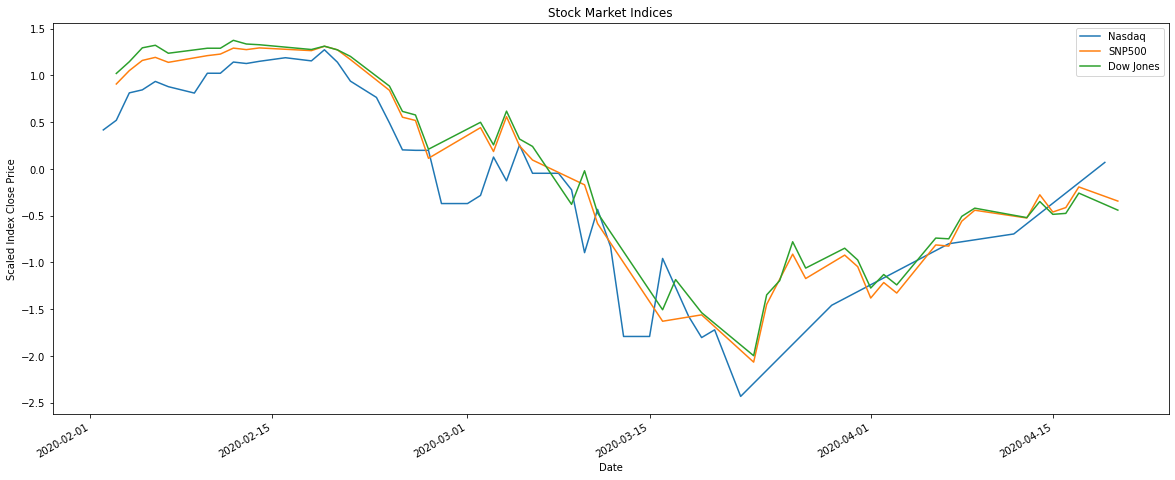

In [30]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
ndx = covid_nasdaq_merged.groupby(['date'])['Close'].median().reset_index() #Median Prices for each day
snp = covid_snp500_merged.groupby(['date'])['Close'].median().reset_index()
dji = covid_dowjones_merged.groupby(['date'])['Close'].median().reset_index()

scaled_features = StandardScaler().fit_transform(ndx[['Close']].values) #scaling values to get meaningful correlation
ndx['Close'] = scaled_features
scaled_features = StandardScaler().fit_transform(snp[['Close']].values)
snp['Close'] = scaled_features
scaled_features = StandardScaler().fit_transform(dji[['Close']].values)
dji['Close'] = scaled_features
ndx.plot(x='date',y='Close',ax=ax,label="Nasdaq",x_compat=True,title="Stock Market Indices") #plots
snp.plot(x='date',y='Close',ax=ax,label="SNP500",x_compat=True,title="Stock Market Indices")
dji.plot(x='date',y='Close',ax=ax,label="Dow Jones",x_compat=True,title="Stock Market Indices")
ax.set_xlabel("Date")
ax.set_ylabel("Scaled Index Close Price")

Here, we have visualized the prices of three exchanges (Nasdaq, Snp500, Dow Jones). The prices are scaled using Standardscaler to find meaningful comparisons, since each of the three indices have completely different index prices. From the plot, we can clearly see that the three exchanges are correlated and they move in the same direction except for a few fluctuations. We can also see a dip in the market after Covid's foothold in the United States followed by a brief recovery.

**Worst and least affected states**

Text(0, 0.5, 'Total Positive Cases')

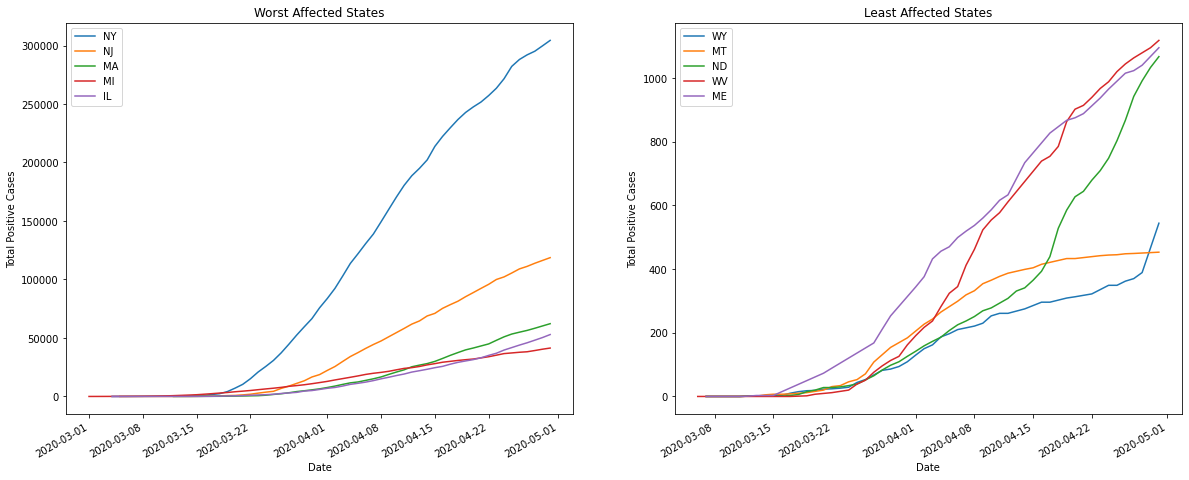

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(20)
usCovidStatesDailyViz = usCovidStatesDaily.groupby(['date','state'])['positive'].sum().reset_index()
statedf = usCovidStatesDaily.groupby('state')['positive'].sum().reset_index()
statedf = statedf.sort_values(['positive'],ascending=False).head(5)
usStates = statedf['state'].unique()
for i in range(0,len(usStates)):
    state = usStates[i]
    newdf = usCovidStatesDailyViz[usCovidStatesDailyViz['state']==state]
    newdf.plot(x='date',y='positive',ax=ax[0],label=state,x_compat=True,title="Worst Affected States")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Total Positive Cases")

statedf = usCovidStatesDaily.groupby('state')['positive'].sum().reset_index()
statedf = statedf.sort_values(['positive'],ascending=True).head(5)
usStates = statedf['state'].unique()
for i in range(0,len(usStates)):
    state = usStates[i]
    newdf = usCovidStatesDailyViz[usCovidStatesDailyViz['state']==state]
    newdf.plot(x='date',y='positive',ax=ax[1],label=state,x_compat=True,title="Least Affected States")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Total Positive Cases")

Over here, we can see the five states worst and least affected by Covid-19. We can also see that for the worst affected states, the graph is started to flatten out, ie. the number of new daily cases are decreasing. Whereas for the least affected states like Maine (ME), we can see a huge spike signifying an exponential rise in cases.

**Visualizing total hospitalizations by date**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



<Figure size 432x288 with 0 Axes>

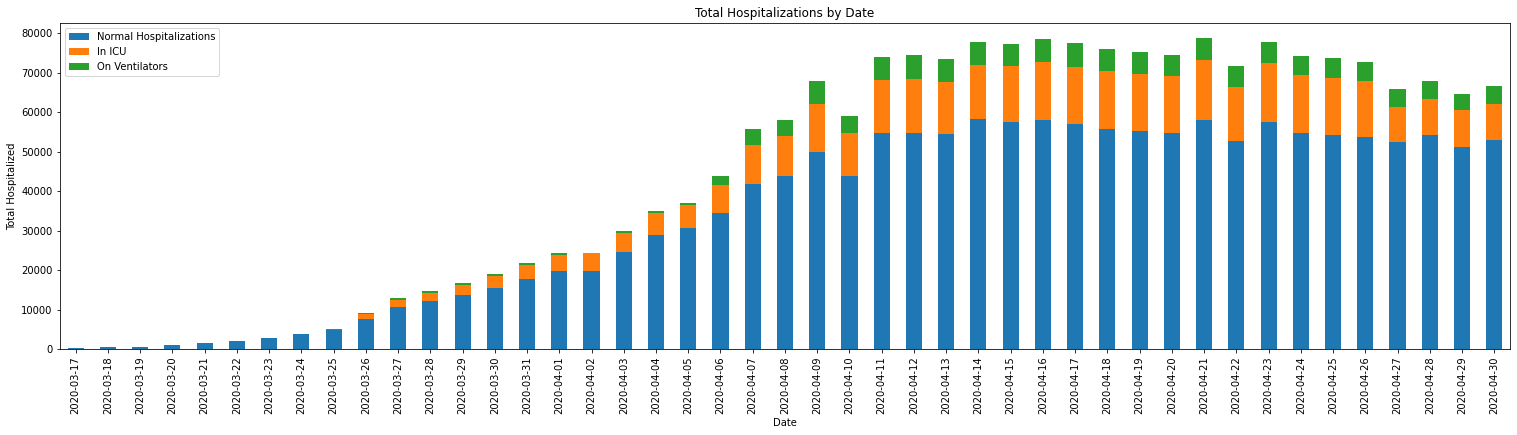

In [32]:
pltdf = usCovidStatesDaily.copy()
plotdf15 = pltdf.groupby(pltdf["date"].dt.date)['hospitalizedCurrently','inIcuCurrently','onVentilatorCurrently'].sum() #Total hospitalizations for the day
plotdf15 = plotdf15[(plotdf15.hospitalizedCurrently != 0) | (plotdf15.inIcuCurrently != 0) | (plotdf15.onVentilatorCurrently != 0) ] #remove dates where all 3 were 0
fig = plt.figure()
ax = plotdf15.plot(kind='bar', stacked=True, figsize=(26,6)) #plot
plt.title("Total Hospitalizations by Date")
plt.xlabel("Date")
plt.ylabel("Total Hospitalized")
ax.legend(["Normal Hospitalizations", "In ICU","On Ventilators"]) #legend
plt.show()

In this visualization, we have used a stacked bar chart to show daily hospitalizations. We are further splitting the data into normal hospitalizations, ICU hospitalizations, and ventilator hospitalizations. We can see that after a certain date the number of hospitalizations has remained constant. This could be due to the fact that the hospitals might have reached their maximum capacity of hospitalizations.

**Distribution of cases across states**

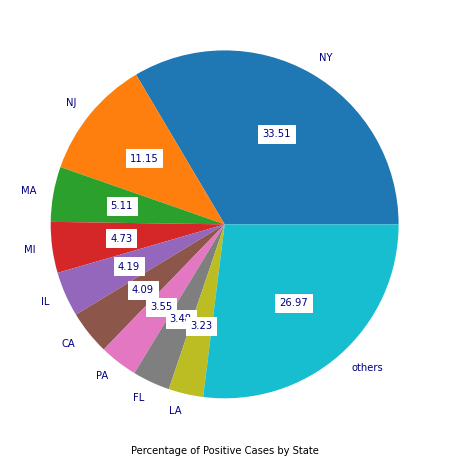

In [33]:
usCovidStatesDailyViz = usCovidStatesDaily.groupby(['state'])['positive'].sum().reset_index()
usCovidStatesDailyViz = usCovidStatesDailyViz.sort_values(['positive'],ascending=False)
top5df = usCovidStatesDailyViz[:9].copy()
#others
otherdf = pd.DataFrame(data = {
    'state' : ['others'],
    'positive' : [usCovidStatesDailyViz['positive'][9:].sum()]
})

#combining top 5 with others
piedf = pd.concat([top5df,otherdf])

usCovidStatesDailyViz.head()
ax = piedf.plot(kind = 'pie', y = 'positive', labels = piedf['state'],figsize=(8,8), autopct='%.2f', textprops={'color':"navy",'size':"medium","backgroundcolor":"white"})
ax.set_xlabel("Percentage of Positive Cases by State")
ax.set_ylabel("")
ax.get_legend().remove()

Through this pie-chart, we can see the distribution of positive Covid cases across all the contiguous states. It can be seen that New York alone has more positive cases than 39 other states of the country. It also has more cases than the other top 6 worst hit states combined.

**Comparison of positive cases, deaths and recovery**

In [34]:
"""
fig = go.Figure()
fig.add_trace(go.Scatter(x=usCovidStatesDailyViz['date'], y=usCovidStatesDailyViz['positiveIncrease'], mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=usCovidStatesDailyViz['date'], y=usCovidStatesDailyViz['deathIncrease'], mode='lines', name='Deaths'))
fig.add_trace(go.Scatter(x=usCovidStatesDailyViz['date'], y=usCovidStatesDailyViz['hospitalizedIncrease'], mode='lines', name='Recovered'))

fig.update_layout(xaxis_title="", yaxis_title="Cases Count in Log Scale", title = 'Positive, Deaths & Hospitalized Daily Increase in USA', yaxis_type='log')
fig.update_layout(legend=dict(x=0, y=1, traceorder="normal", bordercolor="silver", borderwidth=1))
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()
"""
usCovidStatesDailyViz = usCovidDaily.copy(deep=True)
fig = go.Figure()
fig.add_trace(go.Scatter(x=usCovidStatesDailyViz['date'], y=usCovidStatesDailyViz['positive'], mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=usCovidStatesDailyViz['date'], y=usCovidStatesDailyViz['death'], mode='lines', name='Deaths'))
fig.add_trace(go.Scatter(x=usCovidStatesDailyViz['date'], y=usCovidStatesDailyViz['recovered'], mode='lines', name='Recovered'))

fig.update_layout(xaxis_title="", yaxis_title="Cases Count in Log Scale", title = 'Positive, Deaths & Recovered Cases in USA',width=850)
fig.update_layout(legend=dict(x=0, y=1, traceorder="normal", bordercolor="silver", borderwidth=1))
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()


We have created this interactive plot to perform time based analysis of positive cases, deaths and recoveries. We can hover mouse to any point on the line graphs to view the corresponding count for the given date. From the graph, we can also notice that the cases were in three digits till mid march (probably due to lack of testing) and then exploded there onwards. Both recovery and deaths also follow a similar pattern with some time lag.

**Visualising testing**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Text(0, 0.5, 'Count')

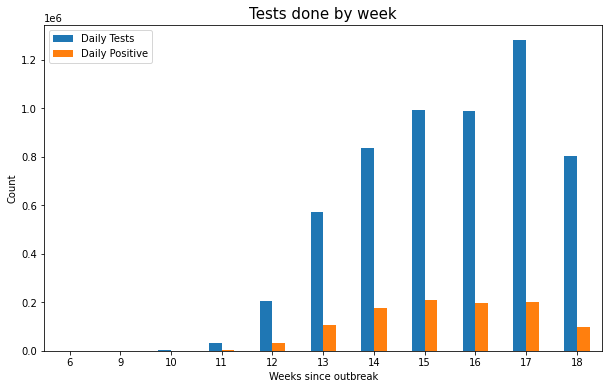

In [35]:
pltdf = usCovidStatesDaily.copy()
plotdf15 = pltdf.groupby(pltdf["date"].dt.week)['positiveIncrease','totalTestResultsIncrease'].sum() #Total hospitalizations for the day
plotdf15 = plotdf15[(plotdf15.positiveIncrease != 0) | (plotdf15.totalTestResultsIncrease != 0) ] #remove dates where all 3 were 0
ax = plotdf15.plot.bar( y=['totalTestResultsIncrease','positiveIncrease'],rot=0,figsize=(10,6),label=['Daily Tests','Daily Positive'])
ax.set_title("Tests done by week", fontsize=15)
ax.set_xlabel("Weeks since outbreak")
ax.set_ylabel("Count")

In this plot, we can see how the testing that was lagging in the initial weeks of outbreak increased exponentially in the coming weeks. We can also see a corresponding increase in positive cases as testing increased.

**Visualising Total Positive cases and deaths**

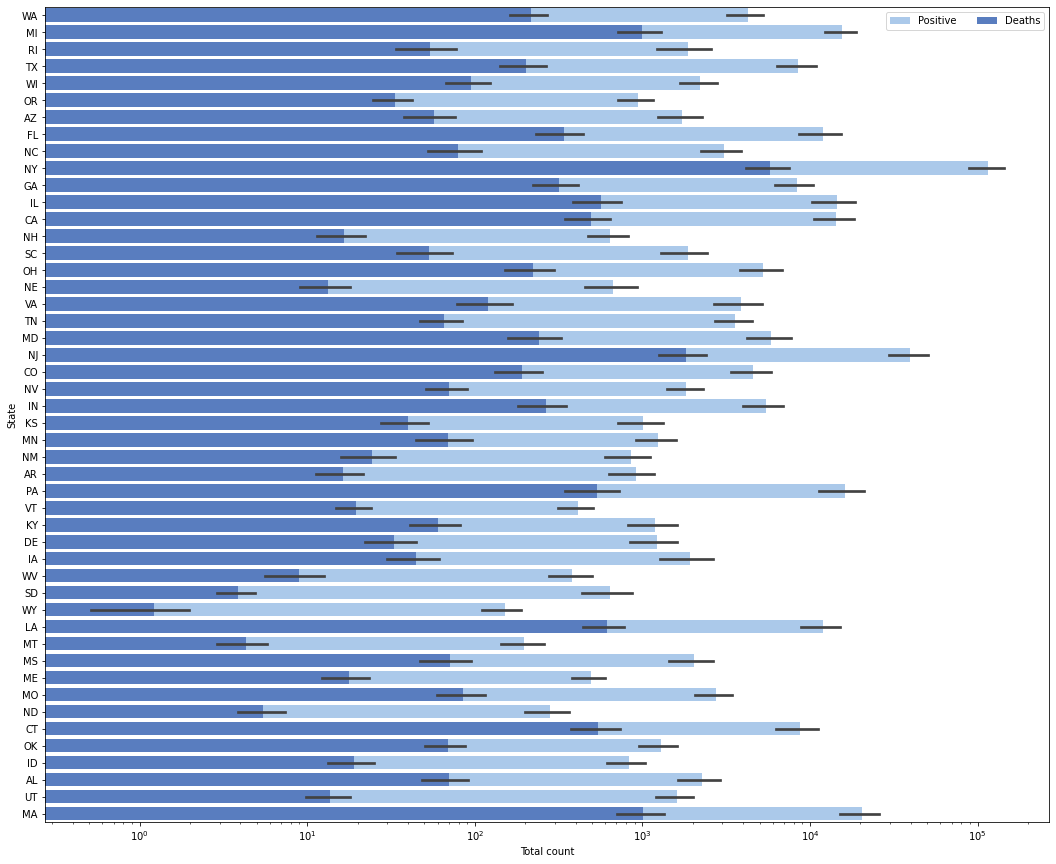

In [36]:
f, ax = plt.subplots(figsize = (18,15))
sns.set_color_codes("pastel")
sns.barplot(x = usCovidStatesDaily['positive'], y =usCovidStatesDaily['state'], data = usCovidStatesDaily,
            label = 'Positive', color = 'b')
sns.set_color_codes("muted")
sns.barplot(x = usCovidStatesDaily['death'], y = usCovidStatesDaily['state'], data = usCovidStatesDaily,
            label = 'Deaths', color = 'b')
ax.set_xscale('log')
ax.legend(ncol = 2, loc = 'upper right',frameon=True)
ax.set(ylabel="State",
       xlabel="Total count")
plt.show()

In this visualization, we see the state wise cumulative positive cases and relative deaths. We have log scaled count since a few states have very high cases and deaths as compared to others

# **3. Required Inferences**
---

In this section, we implement the required inferences

---

##**3.1 Predicting Fatality and Cases using Linear Regression** 




**Autoregression for p = 3 and p = 5**

In [37]:
def data_prep():
  try:
    data=usCovidDaily[['date','deathIncrease','positiveIncrease']]
    data=data[(data['date']>'2020-02-29')&(data['date']<'2020-04-01')].reset_index(drop=True) #data between 1st March and 1st April
  except FileNotFoundError as e:
    print("Load files from colab")
  return data

###################################################################################################################################################
def MAPE(a,b,N): #MAPE
  return 100*sum(abs(a-b)/abs(a))/N

def MSE(a,b,N): #MSE
  return sum((a-b)**2)/N

def AR(data,p=3,col='death'):
  """
  beta = (X*X.T)^-1 X.T*y 
  data : dataset
  p : AR(p) factor
  col : death or positive Default: death

  """
  s=21
  data=data.iloc[0:s+7] #28 days of data
  dates = data['date'][-7:]
  data=data[col]
  samples=len(data)-p
  beta=np.zeros(shape=(samples,)) #Initialize weights to 0
  y=beta
  X=np.zeros(shape=(samples,p+1)) 
  N=len(X)

  #Generate the data for training and testing
  for i in range(p,len(data)):
    row = [1]+[data[i-k] for k in range(1,p+1)]
    X[i-p,:]=row
    y[i-p]=data[i]
  
  y_pred=[]
  N=len(X)-7
  true_val=[]
  for i in range(7):
    X_test = X[N+i,:]
    y_test = y[N+i]
    X_train = X[:N+i,:]
    y_train = y[:N+i]
    true_val.append(y_test)
    a=np.linalg.inv(np.matmul(X_train.T,X_train)) # (X.T * X)^-1
    b=np.matmul(a,X_train.T) #(X.T * X)^-1 * X.T 
    beta = np.matmul(b,y_train) #(X.T * X)^-1 * X.T * y
    y_hat=np.matmul(X_test,beta) #Prediction for N+i data samples
    y_pred.append(y_hat)
  
  y_hat = np.array(y_pred)
  
  mape = MAPE(np.array(true_val),y_hat,7)
  mse = MSE(np.array(true_val),y_hat,7)
  print('Value of p:'+str(p))
  d=pd.DataFrame()
  d['True Values']=true_val
  d['Prediction']=y_hat
  print(d)
  print("---------------------------------")
  print("MSE = " +str(mse))
  print("MAPE = "+str(mape))
  print("---------------------------------")

  return dates,y_hat,np.array(true_val)
  
def genereate_AR_predictions(col):
  print("Data feature to be predicted:"+str(col))
  dates,y_h1,y=AR(data,3,col)
  dates,y_h2,y=AR(data,5,col)
  #plt.figure(figsize=(8,6))
  #plt.plot(dates,y_h1)
  #plt.plot(dates,y_h2)
  #plt.plot(dates,y)
  #plt.xlabel('Date')
  #plt.ylabel(type)
  #plt.legend(['prediction p=3','prediction p=5','true value'])

data=data_prep()
genereate_AR_predictions('deathIncrease')
genereate_AR_predictions('positiveIncrease')

Data feature to be predicted:deathIncrease
Value of p:3
   True Values  Prediction
0        129.0   69.081311
1         82.0  149.191845
2        204.0  210.231030
3        224.0  188.053978
4        275.0  254.066079
5        363.0  494.878796
6        414.0  460.013452
---------------------------------
MSE = 4197.631331559175
MAPE = 28.93551011697028
---------------------------------
Value of p:5
   True Values  Prediction
0        129.0   76.934138
1         82.0  122.683701
2        204.0  266.498170
3        224.0  228.138392
4        275.0  226.139916
5        363.0  493.173435
6        414.0  615.703223
---------------------------------
MSE = 9757.969424200011
MAPE = 32.115370831283926
---------------------------------
Data feature to be predicted:positiveIncrease
Value of p:3
   True Values    Prediction
0       8913.0  10063.404522
1      10614.0  11980.446454
2      10062.0  13969.719025
3      12041.0  10684.167977
4      17153.0  14921.892133
5      17963.0  20413.018604
6 

**EWMA for alpha = 0.5 and alpha = 0.8**

In [38]:
###################################################################################################################################################

def EWMA(alpha,X,col='deathIncrease'):
  """
  alpha : confidence
  X : Time series data
  col : death or positive Default: death
  """
  s=21
  X=X.iloc[0:s+7] #28 Days of data
  N=len(X)
  test = X.iloc[s:s+7]
  y_hat=np.zeros(shape=(N))
  y_hat[0]=X[col][0] #y_hat_1 = y_1
  for i in range(1,N):
    y_hat[i] = alpha * X[col][i-1] + (1-alpha)*y_hat[i-1] #y_t+1|t = alpha*y_t + (1-alpha)*y_hat_t|t-1
  mse=MSE(X[col][s:s+7],y_hat[s:s+7],7) #calculate mse
  print('Value of alpha:'+str(alpha))
  d=pd.DataFrame()
  d['True Values']=X[col][s:s+7] #True values
  d['Prediction']=y_hat[s:s+7] #Predicted Values
  print(d)
  print("---------------------------------")
  print('Mean Squared error = '+str(mse))
  mape = MAPE(np.array(X[col][s:s+7]),np.array(y_hat[s:s+7]),7)  #calculate mape
  print('MAPE = '+str(mape))
  print("---------------------------------")
  dates = X['date'][s:s+7]
  return dates,X[col][s:s+7],y_hat[s:s+7]
  
def generate_EWMA_predictions(col):
  print("Data feature to be predicted:"+str(col))
  dates,y_t,y_h1 = EWMA(0.5,data,col)
  print("---------------------------------")
  dates,y_t,y_h2 = EWMA(0.8,data,col)
  #plt.figure(figsize=(8,6))
  #plt.plot(dates,y_h1)
  #plt.plot(dates,y_h2)
  #plt.plot(dates,y_t)
  #plt.xlabel('Date')
  #plt.ylabel(type)
  #plt.legend(['prediction alpha=0.5','prediction alpha=0.8','true value'])

######################################################################################################################################################

generate_EWMA_predictions('deathIncrease')
generate_EWMA_predictions('positiveIncrease')

Data feature to be predicted:deathIncrease
Value of alpha:0.5
    True Values  Prediction
21        129.0   49.488697
22         82.0   89.244349
23        204.0   85.622174
24        224.0  144.811087
25        275.0  184.405544
26        363.0  229.702772
27        414.0  296.351386
---------------------------------
Mean Squared error = 9496.489202602814
MAPE = 37.41910819592096
---------------------------------
---------------------------------
Value of alpha:0.8
    True Values  Prediction
21        129.0   52.482347
22         82.0  113.696469
23        204.0   88.339294
24        224.0  180.867859
25        275.0  215.373572
26        363.0  263.074714
27        414.0  343.014943
---------------------------------
Mean Squared error = 5810.949996222759
MAPE = 34.32545706724126
---------------------------------
Data feature to be predicted:positiveIncrease
Value of alpha:0.5
    True Values    Prediction
21       8913.0   5434.964435
22      10614.0   7173.982217
23      10062.0   

## **3.2 Hypothesis Testing**

In [0]:
#Get second last week covid data (17-23rd April)
secondlastweekdf = usCovidDaily[(usCovidDaily['date'] > '2020-04-16') & (usCovidDaily['date'] < '2020-04-24')].reset_index(drop=True)
mean_deaths_secondlastweek = secondlastweekdf['deathIncrease'].mean() #daily mean deaths
mean_cases_secondlastweek = secondlastweekdf['positiveIncrease'].mean() #daily mean positive
#Get last week's covid data (24-30th April)
lastweekdf = usCovidDaily[(usCovidDaily['date'] > '2020-04-23') & (usCovidDaily['date'] < '2020-05-01')].reset_index(drop=True)
mean_deaths_lastweek = lastweekdf['deathIncrease'].mean() #daily mean deaths
mean_cases_lastweek = lastweekdf['positiveIncrease'].mean() #daily mean positive

**One sample Walds test**

In [40]:
def OneSampleWalds(TrueMean,Estimator,sampledistribution):
  #MLE Estimator is the sample mean for poisson distribution
  n = len(sampledistribution)
  se_hat = math.sqrt(Estimator/n) # root(sample_mean/n)
  w = (Estimator-TrueMean)/se_hat #formula for wald's statistic
  return abs(w)

print("One sample walds test for number of Deaths:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths")
W = OneSampleWalds(mean_deaths_secondlastweek,mean_deaths_lastweek,lastweekdf)
print("|W| = ",W)
z_alphaby2 = 1.96 # since alpha is 0.05
if(W>z_alphaby2): #compare with critical value
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("One sample walds test for number of Cases:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases")
W = OneSampleWalds(mean_cases_secondlastweek,mean_cases_lastweek,lastweekdf)
print("|W| = ",W)
z_alphaby2 = 1.96 # since alpha is 0.05
if(W>z_alphaby2): #compare with critical value
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")

One sample walds test for number of Deaths:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths
|W| =  12.151367225319705
We Reject the Null Hypothesis

One sample walds test for number of Cases:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases
|W| =  8.161871441285172
We Reject the Null Hypothesis


Applicability:

One sample Wald's test is not applicable since MLE is an asymptotically normal estimator of lambda for poisson distribution if n (number of samples) is large, which is not the case here (n<30).

**One Sample T-test**


In [41]:
def FindSampleStdDev(sampledistro): #find the sample std dev
  x_mean = sampledistro.mean()  #sample mean
  squaredsum=0
  for i in range(0,len(sampledistro)):
    diff = sampledistro[i]-x_mean
    squaredsum = squaredsum + (diff*diff)
  stddev = math.sqrt(squaredsum/len(sampledistro)) #stddev
  return stddev

def OneSampleTtest(TrueMean,SampleMean,sampledistribution):
  n = len(sampledistribution) #no. of samples
  samplestddev = FindSampleStdDev(sampledistribution)
  T = (SampleMean - TrueMean)/(samplestddev/math.sqrt(n)) #T-test formula
  return abs(T)

print("One sample T-test for number of Deaths:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths")
T = OneSampleTtest(mean_deaths_secondlastweek,mean_deaths_lastweek,lastweekdf[['deathIncrease']].values)
print("|T| = ",T)
T_alphaby2 = 2.447 # since n-1 = 6 and alpha is 0.05 #Critical value for T distribution
if(T>T_alphaby2): #Condition to reject
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  
  
print("")
print("One sample T-test for number of Cases:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases")
T = OneSampleTtest(mean_deaths_secondlastweek,mean_deaths_lastweek,lastweekdf[['positiveIncrease']].values)
print("|T| = ",T)
T_alphaby2 = 2.447 # since n-1 = 6 and alpha is 0.05
if(T>T_alphaby2):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

One sample T-test for number of Deaths:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths
|T| =  1.213348941203299
We Accept the Null Hypothesis

One sample T-test for number of Cases:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases
|T| =  0.11137227914507308
We Accept the Null Hypothesis


Applicability:

One sample T-test is may or may not be applicable since we do not know if the sample data is normally distributed. It would be applicable if the sample data would be normally distributed

**Z-test**

In [42]:
def Ztest(TrueMean,SampleMean,wholedistribution,n):
  truesigma = FindSampleStdDev(wholedistribution)
  Z = (SampleMean - TrueMean)/(truesigma/math.sqrt(n))
  return abs(Z)

print("Z-test for number of Deaths:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths")
Z = Ztest(mean_deaths_secondlastweek,mean_deaths_lastweek,usCovidDaily[['deathIncrease']].values,len(lastweekdf))
print("|Z| = ",Z)
Z_alphaby2 = 1.96 # since alpha is 0.05
if(Z>Z_alphaby2):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("Z-test for number of Cases:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases")
Z = Ztest(mean_deaths_secondlastweek,mean_deaths_lastweek,usCovidDaily[['positiveIncrease']].values,len(lastweekdf))
print("|Z| = ",Z)
Z_alphaby2 = 1.96 # since alpha is 0.05
if(Z>Z_alphaby2):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  


Z-test for number of Deaths:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths
|Z| =  0.6081520507116286
We Accept the Null Hypothesis

Z-test for number of Cases:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases
|Z| =  0.03915746001885016
We Accept the Null Hypothesis


Applicability:

Z-test may or may not be applicable since we don't know if the sample data is normally distributed. Also the number of samples is not very large (infinity). It would be applicable if the sample data were normally distributed

**Two Sample Walds Test**

In [43]:
def TwoSampleWalds(Mean_1,Mean_2,n):
  #MLE Estimator is the sample mean for poisson distribution
  se_hat = math.sqrt( (Mean_1/n) + (Mean_2/n) ) #estimator for std error
  w = (Mean_1-Mean_2)/se_hat #formula for two sample walds
  #print(Estimator-TrueMean)
  return abs(w)

print("Two sample walds test for number of Deaths:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths")
W = TwoSampleWalds(mean_deaths_secondlastweek,mean_deaths_lastweek,len(lastweekdf))
print("|W| = ",W)
z_alphaby2 = 1.96 # since alpha is 0.05 # critical value
if(W>z_alphaby2): #condition to reject
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("Two sample walds test for number of Cases:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases")
W = TwoSampleWalds(mean_cases_secondlastweek,mean_cases_lastweek,len(lastweekdf))
print("|W| = ",W)
z_alphaby2 = 1.96 # since alpha is 0.05
if(W>z_alphaby2): #condition to reject
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

Two sample walds test for number of Deaths:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths
|W| =  8.363821241961688
We Reject the Null Hypothesis

Two sample walds test for number of Cases:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases
|W| =  5.744548642464007
We Reject the Null Hypothesis


Applicability:

Two sample Wald's test is not applicable here since MLE is an asymptotically normal estimator if n (number of samples) is large, which is not the case here (n<30).

**Two sample paired t-test**

In [44]:
def TwoSamplePairedTtest(Xarr,Yarr):
  samplemeanx = Xarr.mean() #sample mean for X
  samplemeany = Yarr.mean() #sample mean for Y
  D = Xarr - Yarr # D = X-Y distribution
  samplestddev = FindSampleStdDev(D) #Std dev of D
  n = len(Xarr) 
  T = (samplemeanx - samplemeany)/(samplestddev/math.sqrt(n)) #formula for t-test
  return abs(T)

print("Two sample paired t-test for number of Deaths:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths")
T = TwoSamplePairedTtest(secondlastweekdf[['deathIncrease']].values,lastweekdf[['deathIncrease']].values)
print("|T| = ",T)
T_alphaby2 = 2.447 # since n-1 = 6 and alpha is 0.05
if(T>T_alphaby2): #condition to reject
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("Two sample paired t-test for number of Cases:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases")
T = TwoSamplePairedTtest(secondlastweekdf[['positiveIncrease']].values,lastweekdf[['positiveIncrease']].values)
print("|T| = ",T)
T_alphaby2 = 2.447 # since n-1 = 6 and alpha is 0.05
if(T>T_alphaby2):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

Two sample paired t-test for number of Deaths:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths
|T| =  1.5489744117536948
We Accept the Null Hypothesis

Two sample paired t-test for number of Cases:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases
|T| =  0.38403186060996586
We Accept the Null Hypothesis


Applicability:

We know that both samples have same sample size. But we do not know if D = X - Y is normally distributed.

Hence, Two sample paired T-test may or may not be applicable

**Two sample unpaired t-test**

In [45]:
def TwoSampleUnPairedTtest(Xarr,Yarr):
  samplemeanx = Xarr.mean() #sample mean for X
  samplemeany = Yarr.mean() #sample mean for Y
  D = Xarr - Yarr # D = X-Y distribution
  samplestddev_x = FindSampleStdDev(Xarr)  #Std dev of X
  samplestddev_y = FindSampleStdDev(Yarr)  #Std dev of Y
  n = len(Xarr) #no. of samples in X
  m = len(Yarr) #no. of samples in Y
  denominator = (samplestddev_x*samplestddev_x/n) + (samplestddev_y*samplestddev_y/m)
  T = (samplemeanx - samplemeany)/math.sqrt(denominator) #formula for unpaired t-test
  return abs(T)

print("Two sample unpaired t-test for number of Deaths:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths")
T = TwoSampleUnPairedTtest(secondlastweekdf[['deathIncrease']].values,lastweekdf[['deathIncrease']].values)
print("|T| = ",T)
T_alphaby2 = 2.179 # since n+m-2 = 12 and alpha is 0.05
if(T>T_alphaby2):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("Two sample unpaired t-test for number of Cases:")
print("Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases")
T = TwoSampleUnPairedTtest(secondlastweekdf[['positiveIncrease']].values,lastweekdf[['positiveIncrease']].values)
print("|T| = ",T)
T_alphaby2 = 2.179 # since n+m-2 = 12 and alpha is 0.05
if(T>T_alphaby2):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

Two sample unpaired t-test for number of Deaths:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of deaths
|T| =  0.9968516573485795
We Accept the Null Hypothesis

Two sample unpaired t-test for number of Cases:
Null Hypothesis: The mean for second last week is same as the mean of last week for number of cases
|T| =  0.260095928754951
We Accept the Null Hypothesis


Applicability:

Two sample unpaired T-test is not applicable since the two samples are not independent. We also do not know if the samples are normally distributed.

## **3.3 Equality of distributions**

**2 Sample K-S Test**

In [46]:
def GetKeyInY(Ykeylist,Yvaluelist,x,y1,y2): #Map a point in one distribution to another and find local max difference
    if(x<Ykeylist[0]): #second distribution has cdf zero at this point
        return max(y1,y2),0
    i=0
    #print(i,len(Ykeylist))
    while((i<len(Ykeylist)) and Ykeylist[i]<=x): #iterate till we reach a point just greater in second distribution
        i = i+1
    if(i>=len(Ykeylist)): #second distribution has cdf 1 at this point
      return max(abs(Yvaluelist[i-1]-y1),abs(Yvaluelist[i-1]-y2)),Ykeylist[len(Ykeylist)-1]
    diff1= abs(Yvaluelist[i-1]-y1)  #diff between left of point and ecdf
    diff2= abs(Yvaluelist[i-1]-y2)  #diff between right of point and ecdf
    #print(diff1,",",diff2)
    if(diff1>diff2):
        return diff1,i-1
    else:
        return diff2,i-1

def GetMaxDif(Xkeylist,Xvaluelist,Ykeylist,Yvaluelist): #Calculates maximum difference between the two estimators
    maxdiff=0
    for i in range(0,len(Xkeylist)): #iterate through one of the distributions
        x = Xkeylist[i] # x in first distro
        y1 = Xvaluelist[i] # y to right of current element in first distro
        if(i>0):
          y2 = Xvaluelist[i-1] # y to left of current element for first distro
        else:
          y2=0
        diff,index = GetKeyInY(Ykeylist,Yvaluelist,x,y1,y2) #Get local maximum difference for this point (left and right)
        #print("i:",i,",",x,",",diff,",",Ykeylist[index])
        if(diff>maxdiff): #Check for global maximum difference and store
            maxdiff = max(maxdiff,diff)
    return maxdiff

def GetProb(X):     #calculates the cdf for points
    X = list(map(float, X))
    X.sort()
    numele = len(X)
    prob = {}
    start = 0
    for i in X:
        start = start + 1/numele #keep adding probability to calculate cdf
        if i in prob.keys():
            count = prob[i]
            count = count + 1/numele
            prob[i] = count
        else:
            prob[i] = start
    keylist = list(prob.keys())
    valuelist = list(prob.values())
    return keylist,valuelist #2 arrays, one for elements and second for their cdf respectively

def TwoSampleKS(X,Y):

    Xkeylist,Xvaluelist = GetProb(X) #cdf for points
    Ykeylist,Yvaluelist = GetProb(Y) #cdf for points
    diff = GetMaxDif(Xkeylist,Xvaluelist,Ykeylist,Yvaluelist) #get max difference 
    return round(diff,4)

print("Two sample K-S test for number of Deaths:")
print("Null Hypothesis: The distribution for second last week is same as the distribution of last week for number of deaths")
D = TwoSampleKS(secondlastweekdf[['deathIncrease']].values,lastweekdf[['deathIncrease']].values)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("Two sample K-S test for number of Cases:")
print("Null Hypothesis: The distribution for second last week is same as the distribution of last week for number of cases")
D = TwoSampleKS(secondlastweekdf[['positiveIncrease']].values,lastweekdf[['positiveIncrease']].values)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  


Two sample K-S test for number of Deaths:
Null Hypothesis: The distribution for second last week is same as the distribution of last week for number of deaths
Max Difference =  0.4286
We Reject the Null Hypothesis

Two sample K-S test for number of Cases:
Null Hypothesis: The distribution for second last week is same as the distribution of last week for number of cases
Max Difference =  0.2857
We Reject the Null Hypothesis


Applicability:

K-S test is applicable here since it has no assumptions

**Permutation Test**

In [47]:
def FindMean(arr): #Find mean of a list
    n = len(arr)
    sum=0
    for i in arr:
        sum = sum+float(i)
    mean = sum/n
    return mean

def PermutationTest(X,Y,noofpermutations=None):
    if(noofpermutations==None):
      noofpermutations = 900000 #Number of permutations kept high since 14! causes overflow
    lenx = len(X) # no. of samples in X
    leny= len(Y)  # no. of samples in Y
    mergedlist = X + Y  
    meanx = statistics.mean(X) #mean of X
    meany = statistics.mean(Y)  #mean of Y
    T_obs = abs(meanx-meany)  #T_obs
    count=0
    for i in range(noofpermutations):
        random.shuffle(mergedlist)         
        x_i = mergedlist[:lenx] #permuted X
        y_i = mergedlist[lenx:] #permuted Y
        mean_x = FindMean(x_i)  
        mean_y = FindMean(y_i)
        T_i = abs(mean_x-mean_y) #T_i
        if(T_i>T_obs):
            count = count+1
    p_value = count/noofpermutations  #p-value
    return p_value

print("Permutation test for number of Deaths:")
print("Null Hypothesis: The distribution for second last week is same as the distribution of last week for number of deaths")
pvalue = PermutationTest(secondlastweekdf['deathIncrease'].tolist(),lastweekdf['deathIncrease'].tolist())
print("p-value = ",pvalue)
criticalval = 0.05 #critical value
if(pvalue<=criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("Permutation test for number of Cases:")
print("Null Hypothesis: The distribution for second last week is same as the distribution of last week for number of cases")
pvalue = PermutationTest(secondlastweekdf['positiveIncrease'].tolist(),lastweekdf['positiveIncrease'].tolist())
print("p-value = ",pvalue)
criticalval = 0.05 #critical value
if(pvalue<=criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

Permutation test for number of Deaths:
Null Hypothesis: The distribution for second last week is same as the distribution of last week for number of deaths
p-value =  0.37099
We Accept the Null Hypothesis

Permutation test for number of Cases:
Null Hypothesis: The distribution for second last week is same as the distribution of last week for number of cases
p-value =  0.8298722222222222
We Accept the Null Hypothesis


Applicability:

Permutation test is applicable here since it has no assumptions

**1 Sample K-S Test for Poisson distribution**

In [48]:
def GetMME_Poisson(Xarr):
  # mme for lambda is sample mean
  lambdahat = FindMean(Xarr) #sample mean
  print("lambda:",lambdahat)
  Yarr = []  #Corresponding CDF for the distribution
  for i in range(0,len(Xarr)):
    cdfx = poisson.cdf(Xarr[i], lambdahat)
    Yarr.append(cdfx)
  return Yarr

def OneSampleKS(X,Y,Y_prob):
    Xkeylist,Xvaluelist = GetProb(X) #Get cdf for data points in X
    Ykeylist = Y 
    Yvaluelist = Y_prob 
    diff = GetMaxDif(Xkeylist,Xvaluelist,Ykeylist,Yvaluelist) #get max difference
    return round(diff,4)

print("1 Sample K-S test for number of Deaths:")
print("Null Hypothesis: The distribution for second last week is poisson which is same as the distribution of last week for number of deaths")
secondlastweekmme_poisson = GetMME_Poisson(secondlastweekdf['deathIncrease'].tolist())
D = OneSampleKS(lastweekdf[['deathIncrease']].values,secondlastweekdf[['deathIncrease']].values,secondlastweekmme_poisson)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("1 Sample K-S test for number of Cases:")
print("Null Hypothesis: The distribution for second last week is poisson which same as the distribution of last week for number of cases")
secondlastweekmme_poisson = GetMME_Poisson(secondlastweekdf['positiveIncrease'].tolist()) #get distribution using MME estimator
D = OneSampleKS(lastweekdf[['positiveIncrease']].values,secondlastweekdf[['positiveIncrease']].values,secondlastweekmme_poisson)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

1 Sample K-S test for number of Deaths:
Null Hypothesis: The distribution for second last week is poisson which is same as the distribution of last week for number of deaths
lambda: 1909.5714285714287
Max Difference =  1.0
We Reject the Null Hypothesis

1 Sample K-S test for number of Cases:
Null Hypothesis: The distribution for second last week is poisson which same as the distribution of last week for number of cases
lambda: 27779.428571428572
Max Difference =  0.7143
We Reject the Null Hypothesis


Applicability:

1-sided K-S test is applicable here since it has no assumptions

**1 Sample K-S Test for Geometric distribution**

In [49]:
def GetMME_Geometric(Xarr):
  # mme estimator for p is inverse of sample mean
  phat = 1/FindMean(Xarr)
  print("p:",phat)
  Yarr = [] #calculate cdf for the distribution
  for i in range(0,len(Xarr)):
    cdfx = geom.cdf(Xarr[i], phat)
    Yarr.append(cdfx)
  #print(Yarr)
  return Yarr

print("1 Sample K-S test for number of Deaths:")
print("Null Hypothesis: The distribution for second last week is geometric which is same as the distribution of last week for number of deaths")
secondlastweekmme_geometric = GetMME_Geometric(secondlastweekdf['deathIncrease'].tolist()) #get cdf distribution using MME
D = OneSampleKS(lastweekdf[['deathIncrease']].values,secondlastweekdf[['deathIncrease']].values,secondlastweekmme_geometric)
print("Max Difference = ",D)
criticalval = 0.05 #critical value
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("1 Sample K-S test for number of Cases:")
print("Null Hypothesis: The distribution for second last week is geometric which is same as the distribution of last week for number of cases")
secondlastweekmme_geometric = GetMME_Geometric(secondlastweekdf['positiveIncrease'].tolist())
D = OneSampleKS(lastweekdf[['positiveIncrease']].values,secondlastweekdf[['positiveIncrease']].values,secondlastweekmme_geometric)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

1 Sample K-S test for number of Deaths:
Null Hypothesis: The distribution for second last week is geometric which is same as the distribution of last week for number of deaths
p: 0.0005236777137727238
Max Difference =  0.5714
We Reject the Null Hypothesis

1 Sample K-S test for number of Cases:
Null Hypothesis: The distribution for second last week is geometric which is same as the distribution of last week for number of cases
p: 3.59978606985642e-05
Max Difference =  0.7143
We Reject the Null Hypothesis


**1 Sample K-S Test for Binomial distribution**

In [50]:
def GetMME_Binomial(Xarr):
  samplemean = FindMean(Xarr) #sample mean
  n=len(Xarr)
  sum = 0
  for i in range(0,n):
    sum = sum + ((Xarr[i]-samplemean)**2)
  variance = sum/n
  n_hat = (samplemean**2)/(samplemean-variance) #mme for n
  print("n:",n_hat)
  p_hat = samplemean/n_hat #mme for p
  print("p:",p_hat)
  Yarr = [] #calculate cdf for the sample
  for i in range(0,len(Xarr)):
    cdfx = prob = binom.cdf(Xarr[i], n_hat, p_hat)
    Yarr.append(cdfx)
  #print(Yarr)
  return Yarr  

print("1 Sample K-S test for number of Deaths:")
print("Null Hypothesis: The distribution for second last week is binomial which is same as the distribution of last week for number of deaths")
secondlastweekmme_binomial = GetMME_Binomial(secondlastweekdf['deathIncrease'].tolist())
D = OneSampleKS(lastweekdf[['deathIncrease']].values,secondlastweekdf[['deathIncrease']].values,secondlastweekmme_binomial)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("1 Sample K-S test for number of Cases:")
print("Null Hypothesis: The distribution for second last week is binomial which is same as the distribution of last week for number of cases")
secondlastweekmme_binomial = GetMME_Binomial(secondlastweekdf['positiveIncrease'].tolist())
D = OneSampleKS(lastweekdf[['positiveIncrease']].values,secondlastweekdf[['positiveIncrease']].values,secondlastweekmme_binomial)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

1 Sample K-S test for number of Deaths:
Null Hypothesis: The distribution for second last week is binomial which is same as the distribution of last week for number of deaths
n: -44.9534692277637
p: -42.478844489093596
Max Difference =  0.5714
We Reject the Null Hypothesis

1 Sample K-S test for number of Cases:
Null Hypothesis: The distribution for second last week is binomial which is same as the distribution of last week for number of cases
n: -121.32284988066395
p: -228.97111796131628
Max Difference =  0.7143
We Reject the Null Hypothesis


We are getting negative values of estimators for n and p in this case using MME. Hence, it does not make sene to calculate CDF using these values for the binomial distribution.

## **3.4 Required Inferences - Pearson Correlation**

In [0]:
def average(x):
    assert len(x) > 0
    return float(sum(x)) / len(x)

def pearson_def(x, y): #calculate the pearson correlation
    assert len(x) == len(y)
    n = len(x)
    assert n > 0
    avg_x = average(x) #mean of x
    avg_y = average(y)  #mean of y
    diffprod = 0
    xdiff2 = 0
    ydiff2 = 0
    for idx in range(n):
        xdiff = x[idx] - avg_x
        ydiff = y[idx] - avg_y
        diffprod += xdiff * ydiff
        xdiff2 += xdiff * xdiff
        ydiff2 += ydiff * ydiff
    return diffprod / math.sqrt(xdiff2 * ydiff2)

In [0]:
setOfCovidFeatures = ['positiveIncrease', 'deathIncrease']
setOfXFeatures = [ 'Close']

def pearsonHelper(df):
  for covidFeature in setOfCovidFeatures:
    for xFeature in setOfXFeatures:
        corr = pearson_def(df[covidFeature], df[xFeature])
        if corr < -0.5: #Threshold for good negative correlation
          print("Correlation :: " + covidFeature + " v/s " + xFeature + " = " + str(corr) + " || Negative Linear Correlation!")
        elif corr > 0.5:  #Threshold for good positive correlation
          print("Correlation :: " + covidFeature + " v/s " + xFeature + " = " + str(corr) + " || Positive Linear Correlation!")
        else: #no correlation
          print("Correlation :: " + covidFeature + " v/s " + xFeature + " = " + str(corr) + " || No Correlation!")

def computePearsonForGivenIndex(index): #get pearson correlation for each stock market index
  start_date = '2020-03-31' #filter data for a month
  end_date = '2020-05-01'
  if index == "dowjones":  #dji index 
    covid_dj_onemonth_df = covid_dowjones_merged[(covid_dowjones_merged['date'] > start_date ) & (covid_dowjones_merged['date'] < end_date)].reset_index(drop=True)
    #print(covid_dj_onemonth_df.head())
    pearsonHelper(covid_dj_onemonth_df)
  elif index == "nasdaq": #ndx
    covid_ndx_onemonth_df = covid_nasdaq_merged[(covid_nasdaq_merged['date'] > start_date ) & (covid_nasdaq_merged['date'] < end_date)].reset_index(drop=True)
    pearsonHelper(covid_ndx_onemonth_df)
  else: #snp
    covid_sp_onemonth_df = covid_snp500_merged[(covid_snp500_merged['date'] > start_date ) & (covid_snp500_merged['date'] < end_date)].reset_index(drop=True)
    pearsonHelper(covid_sp_onemonth_df)

  

**Pearson Correlation Analysis for Dowjones**



In [53]:
computePearsonForGivenIndex("dowjones") 

Correlation :: positiveIncrease v/s Close = 0.00976053251788004 || No Correlation!
Correlation :: deathIncrease v/s Close = 0.07876932312430697 || No Correlation!


Findings:

First let us put some meaning to all the corresponding column names here - 

Covid Data Set - 
1. deathIncrease :- Daily number of deaths
2. positiveIncrease:- Daily positive cases

X Data Set (Stock Market Prices)- 
1. Close :- Close value of the Given Index

From the above correlation statistics

-- There seems to be no correlation between #deaths and Close Price of X (DowJones Index) or #cases and Close Price of X (DowJones Index) 

 **Pearson Correlation for Nasdaq**



In [54]:
computePearsonForGivenIndex("nasdaq") 

Correlation :: positiveIncrease v/s Close = -0.029097837544274377 || No Correlation!
Correlation :: deathIncrease v/s Close = -0.017657238491642448 || No Correlation!


**Findings**

From the above correlation statistics - 

-- There seems to be no correlation between #deaths and Close Price of X (Nasdaq Index) or #cases and Close Price of X (Nasdaq Index) 

**Pearson Correlation Analysis for SNP500**



In [55]:
computePearsonForGivenIndex("snp500") 

Correlation :: positiveIncrease v/s Close = 0.0077769785264223635 || No Correlation!
Correlation :: deathIncrease v/s Close = 0.07890937891635293 || No Correlation!


**Findings**

From the above correlation statistics - 

-- There seems to be no correlation between #deaths and Close Price of X (SNP500 Index) or #cases and Close Price of X (SNP500 Index) 

## **3.5 Bayesian Inference**

Given: X1, X2,..Xn ~ poisson(lambda), lambda ~ exp(1/B) 
We calculated lambda_mme and equated it to the mean of exp distribution. 
Taking 1/B = L, we get L = 1/lambda_mme.
We calculated the posterior for all 4 weeks and got the same distribution pattern for all posteriors. This pattern is Gamma distribution with:
alpha = sum of data till now + 1  
beta = len(data till now) + L



Initial prior: 1.75
Week 1
MAP value: 0.45454545454545453
Posterior Distribution Alpha -  5.0
Posterior Distribution Beta -  8.75
-------------------------------------------------
Week 2
MAP value: 5.0
Posterior Distribution Alpha -  83.0
Posterior Distribution Beta -  15.75
-------------------------------------------------
Week 3
MAP value: 14.545454545454545
Posterior Distribution Alpha -  333.0
Posterior Distribution Beta -  22.75
-------------------------------------------------
Week 4
MAP value: 36.36363636363636
Posterior Distribution Alpha -  1080.0
Posterior Distribution Beta -  29.75
-------------------------------------------------


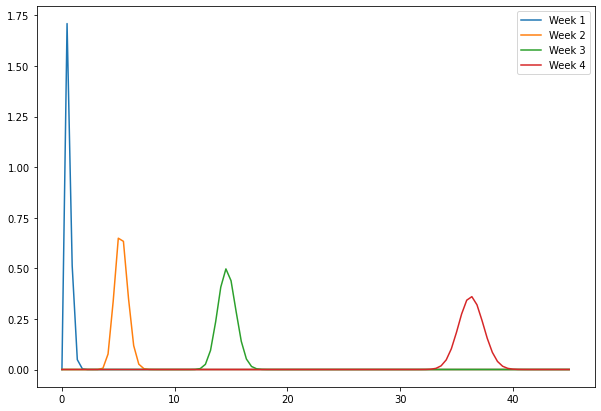

In [56]:
usCovidStatesDailyBay = usCovidStatesDaily.groupby(['date']).sum()
month_data = usCovidStatesDailyBay.iloc[20:48] #Data for a month

def calculate_mme_poisson(d): #mme is sample mean
  i_sum = 0.0
  for i in d:
    i_sum += i
  return i_sum/float(len(d))

week1 = month_data.iloc[0:7,]
week2 = month_data.iloc[7:14,]
week3 = month_data.iloc[14:21,]
week4 = month_data.iloc[21:28,]
weekData = [list(week1['death'].values),list(week2['death'].values),list(week3['death'].values),list(week4['death'].values)]
# calculating lambda_mme
mme_lambda = calculate_mme_poisson(weekData[0])
B = (1/mme_lambda)
print("Initial prior:",B)

# calculating and alpha and beta
alpha_list = []
beta_list = []


#initialize n and s to 0 to keep track of previous n and sum.
n = 0
s = 0
for i in range(0,len(weekData)):
  s =  s + sum(weekData[i]) 
  a = s + 1
  n = n + len(weekData[i]) 
  b = n + B
  alpha_list.append(a)
  beta_list.append(b)

x = np.linspace(0, 45, 100)
fig, ax = plt.subplots(figsize=(10, 7))
for i in range(len(alpha_list)):
  y = gamma.pdf(x,alpha_list[i],scale = 1/beta_list[i])
  #calculating the MAP
  max_y = max(y)
  max_x = x[y.argmax()]
  plt.plot(x,gamma.pdf(x,alpha_list[i],scale = 1/beta_list[i]), label = "Week "+str(i+1))
  print("Week",i+1)
  print("MAP value:",max_x)
  print("Posterior Distribution Alpha - ", alpha_list[i])
  print("Posterior Distribution Beta - ", beta_list[i])
  print("-------------------------------------------------")

plt.legend()
plt.show()

# **4. Own Inferences**
---

In this section, we implement our own inferences

---

## **4.1 Checking if closing non-essential businesses on 20th March had any effect on new cases in New York**

In this inference, we check if the enforcement of closing non-essential businesses had any impact in New York. The reason this inference is useful, is because it helps us know whether such a costly measure to close economy is actually effective or not. Other states in the US are following New York's covid trajectory, and such an inference would help determine policies in those states.

For our task, we are using paired T-test to check if the sample means of positive cases before and after enforcement of lockdown are same or different. Since the policy was passed on 20th March, and Covid patients take approximately one-two weeks to show symptoms, we have maintained a time lag to compare samples. The sample data before shutdown is taken for the time slice between 12th March to 3rd April (3 weeks), and the sample data after shutdown is taken for the time slice between 4th April and 24th April (3 weeks) respectively.

We are using paired T-test since both the samples are dependent, and have same sample size. We are making an assumption that the difference sample D is normally distributed

In [57]:
NyStatedata = usCovidStatesDaily[usCovidStatesDaily['state']=='NY'] #filter data by state and time slices
databeforelockdown = NyStatedata[(NyStatedata['date'] > '2020-03-12' ) & (NyStatedata['date'] < '2020-04-03')].reset_index(drop=True)
dataafterlockdown = NyStatedata[(NyStatedata['date'] > '2020-04-02' ) & (NyStatedata['date'] < '2020-04-24')].reset_index(drop=True)

print("Two sample paired t-test for number of Cases:")
print("Null Hypothesis: The means of positive cases before lockdown and after lockdown are same")

T = TwoSamplePairedTtest(databeforelockdown[['positiveIncrease']].values,dataafterlockdown[['positiveIncrease']].values)
print("|T| = ",T)
T_alphaby2 = 2.086 # since n-1 = 20 and alpha is 0.05
if(T>T_alphaby2):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

Two sample paired t-test for number of Cases:
Null Hypothesis: The means of positive cases before lockdown and after lockdown are same
|T| =  3.5246392349826396
We Reject the Null Hypothesis


The paired T-test rejects the null hypothesis. This indeed means that the means of new positive cases before and after shutdown in New York are different.

## **4.2 Check if Stock Market Prices are Independent of Covid**

In this inference, we test if the stock market prices are actually dependent on Covid. Since stock market prices are dependent on various factors, it is necessary to evaluate how weighting the covid outbreak is towards driving market prices. Or if it's not dependent, it would mean that the market prices are weighed more by sentiment than by actual data.

In order to analyse this, we are using the Chi-square test of independence. We are considering index prices for three markets (Nasdaq, Dow Jones, SNP500) pre and post covid outbreak. 

In [58]:
#Filter data for the markets pre and post covid (pre: before 1st February, post:after 1st February)
dowjones_pre =  dowjones[(dowjones['date'] > '2019-10-31' ) & (dowjones['date'] < '2020-02-01')].reset_index(drop=True)
dowjones_post =  dowjones[(dowjones['date'] > '2020-01-31' ) & (dowjones['date'] < '2020-05-01')].reset_index(drop=True)
nasdaq_pre =  nasdaq[(nasdaq['date'] > '2019-10-31' ) & (nasdaq['date'] < '2020-02-01')].reset_index(drop=True)
nasdaq_post =  nasdaq[(nasdaq['date'] > '2020-01-31' ) & (nasdaq['date'] < '2020-05-01')].reset_index(drop=True)
snp500_pre =  snp500[(snp500['date'] > '2019-10-31' ) & (snp500['date'] < '2020-02-01')].reset_index(drop=True)
snp500_post =  snp500[(snp500['date'] > '2020-01-31' ) & (snp500['date'] < '2020-05-01')].reset_index(drop=True)
#Get mean index prices
dowjones_pre_price = int(dowjones_pre['Close'].mean())
nasdaq_pre_price = int(nasdaq_pre['Close'].mean())
snp500_pre_price = int(snp500_pre['Close'].mean())
dowjones_post_price = int(dowjones_post['Close'].mean())
nasdaq_post_price = int(nasdaq_post['Close'].mean())
snp500_post_price = int(snp500_post['Close'].mean())
print("Using Chi-square test:")
print("Null hypothesis: Stock Market Prices are independent of Covid\n") #null hypothesis
observedvalues = [] 
total_r1 = dowjones_pre_price+nasdaq_pre_price+snp500_pre_price 
total_r2 =dowjones_post_price+nasdaq_post_price+snp500_post_price
pre_indexvals = ["Pre-covid index prices",dowjones_pre_price,nasdaq_pre_price,snp500_pre_price,total_r1]
post_indexvals = ["Post-covid index prices",dowjones_post_price,nasdaq_post_price,snp500_post_price,total_r2 ]
header = ["","Dow Jones","Nasdaq","Snp500","Total_R"]
total_c = ["Total_C",dowjones_pre_price+dowjones_post_price,nasdaq_pre_price+nasdaq_post_price,snp500_pre_price+snp500_post_price,total_r1+total_r2]
observedvalues=[header,pre_indexvals,post_indexvals,total_c] #store observed values in this
#pre_indexvals.append()
print("Observed Values:")
observeddf = pd.DataFrame(np.matrix(observedvalues))
print(observeddf)

expectedvalues = copy.deepcopy(observedvalues) #calculate expected values
for r in range(1,3):
  for c in range(1,4):
    expectedvalues[r][c] = round(expectedvalues[r][4]*expectedvalues[3][c]/expectedvalues[3][4],2)
expecteddf = pd.DataFrame(np.matrix(expectedvalues))

print()
print("Expected Values:")
print(expecteddf)
q_obs =0  #calculate Q_OBS
for r in range(1,4):
  for c in range(1,3):
    numerator = (expectedvalues[r][c]-observedvalues[r][c])**2
    term = numerator/expectedvalues[r][c]
    q_obs = q_obs + term
print("\nQ_Obs: ",q_obs)
pvalue = 1 - stats.chi2.cdf(q_obs, 2) #p-value for the corresponding chi square statistic with df=(3-1)*(2-1)=2
print("p-value: ",pvalue)
alpha = 0.05
if(pvalue<=alpha):
  print("We reject null hypothesis")
else:
  print("We accept the null hypothesis")

Using Chi-square test:
Null hypothesis: Stock Market Prices are independent of Covid

Observed Values:
                         0          1       2       3        4
0                           Dow Jones  Nasdaq  Snp500  Total_R
1   Pre-covid index prices      28289    8627    3187    40103
2  Post-covid index prices      25085    8687    2940    36712
3                  Total_C      53374   17314    6127    76815

Expected Values:
                         0          1        2        3        4
0                           Dow Jones   Nasdaq   Snp500  Total_R
1   Pre-covid index prices    27865.1  9039.16  3198.74    40103
2  Post-covid index prices    25508.9  8274.84  2928.26    36712
3                  Total_C      53374    17314     6127    76815

Q_Obs:  52.8153940238725
p-value:  3.3985037006800667e-12
We reject null hypothesis


From the Chi-square test of independence, we can infer than the distributions of stock market prices and Covid-19 are independent. 

We can thus say that the market volatility is presumably because of sentiment rather than figures (Covid positive cases/deaths)

##**4.3 Check if distributions of hospitalizations and positive cases are same for two worst affected states (NY and NJ)**

With this inference, we are testing if the distributions of positive cases and hospitalizations were same for the two worst affected states in US: New York and New Jersey.

Both the states had different proactive measures implemented towards dealing with the outbreak. By analysing and comparing the distributions, we can evaluate if the containment policies actually have any effect on growth of positive cases or hospitalizations.

In this inference, we are using two sample K-S test to check equivalence of distributions for both number of daily hospitalizations and deaths.

In [59]:
NyStatedata = usCovidStatesDaily[usCovidStatesDaily['state']=='NY']
NJStatedata = usCovidStatesDaily[usCovidStatesDaily['state']=='NJ']

print("Two sample K-S test for number of hospitalizations for NY and NJ:")
print("Null Hypothesis: The distributions for hospitalizations is same in NY and NJ")
D = TwoSampleKS(NyStatedata[['hospitalizedCurrently']].values,NJStatedata[['hospitalizedCurrently']].values)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

print("")
print("Two sample K-S test for number of positive cases for NY and NJ:")
print("Null Hypothesis: The distributions for positive cases is same in NY and NJ")
D = TwoSampleKS(NyStatedata[['positiveIncrease']].values,NJStatedata[['positiveIncrease']].values)
print("Max Difference = ",D)
criticalval = 0.05
if(D>criticalval):
  print("We Reject the Null Hypothesis")
else:
  print("We Accept the Null Hypothesis")  

Two sample K-S test for number of hospitalizations for NY and NJ:
Null Hypothesis: The distributions for hospitalizations is same in NY and NJ
Max Difference =  0.569
We Reject the Null Hypothesis

Two sample K-S test for number of positive cases for NY and NJ:
Null Hypothesis: The distributions for positive cases is same in NY and NJ
Max Difference =  0.6379
We Reject the Null Hypothesis


For both hospitalizations and deaths, K-S test rejects the null hypothesis that the respective distributions are same for New York and New Jersey.

Given the distributions are different, this means that even though they had a similar outbreak timeline and shared borders, mitigation policies in each state did shape the course of outbreak differently in both the states.